# Analysis of FastMap Algorithm on Directed Graph

The content of this analysis includes:

1. Dataset - testing graph:
    - Generated random graph
    - Directed networks from [Stanford Large Network Dataset Collection (SNAP)](https://snap.stanford.edu/data/)
        - Internet peer-to-peer networks
2. Variant of FastMap on directed graph:
    - Two embeddings:
        1. $h_1(i, j)=\frac{d_{ij}+d_{ji}}{2}$
        2. $h_2(i, j)=\frac{|d_{ij}-d_{ji}|}{2}$
    - A byproduct: every nodes' distances with some pivot nodes
3. Evaluation:
    - Precision of picking the bigger one of $d_{ij}$ and $d_{ji}$, using stroed distances
    - Distortion of embedding:
        1. Using real comparation result of $d_{ij}$ and $d_{ji}$, then $h(i,j)=h_1(i, j)\pm h_2(i, j)$
        2. Using prediction of comparation result of $d_{ij}$ and $d_{ji}$, then $h(i,j)=h_1(i, j)\pm h_2(i, j)$
        3. Using stroed distances to fine-tune heuristic value from embedding.

In [3]:
# Add libraries
import os, sys
lib_path = os.path.abspath(os.path.join('../heuristic/'))
sys.path.append(lib_path)

import fastmap.utils as utils
import fastmap.difastmap as fm
import fastmap.analyse as analyse

import matplotlib.pyplot as plt
import networkx as nx
import random

## Generate random testing graph:

1. `generate_random_digraph(n, p, low, high)`: generate a directed graph with `n` nodes, and every edge have positive weith range in `[low, high]`, it make sure the graph is strongly connected, otherwise there is a warning for increasing `p` (the probability of an directed edge exist between two nodes). Density $D = \frac{|E|}{|V|(|V|-1)}$ is also printed.

2. `distance_info(G)`: show the distribution of distances between nodes.

In [5]:
def generate_random_digraph(n, p, low, high):
    for i in range(100):
        G = nx.gnp_random_graph(n, p, directed = True)
        if nx.is_strongly_connected(G):
            break
    if nx.is_strongly_connected(G) == False:
        print("Unable to generate strongly connected graph, try increase 'p'.")
    density = float(len(G.edges()))/(n*(n-1))
    print("Density: {}".format(density))
    for (n1, n2) in G.edges():
        G[n1][n2]['weight']=random.randint(low, high)
    return G

def distance_info(G):
    dis = []
    for node in list(G.nodes()):
        length = nx.single_source_dijkstra_path_length(G, node)
        dis.extend(list(length.values()))
    x = list(set(dis))
    y = []
    for i in x:
        y.append(dis.count(i))
    plt.plot(x,y,'r-o', linewidth=1)
    plt.xlabel('distance')
    plt.ylabel('count')
    plt.title('Statistic of pair distances')
    plt.show()

An example:

Density: 0.0070200200200200204


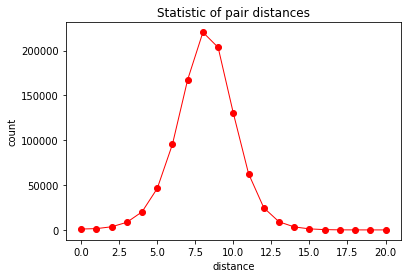

In [7]:
n = 1000
p = 0.007
low = 1
high = 5

G = generate_random_digraph(n, p, low, high)
distance_info(G)